## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка данных из файла CSV
data = pd.read_csv('application_train.csv')

# Запись в Y столбца с целевой переменной
Y = data['TARGET']

# Удаление ненужных столбцов
columns_to_drop = ['SK_ID_CURR', 'TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 
                   'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                   'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
                   'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 
                   'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 
                   'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 
                   'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 
                   'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 
                   'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                   'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 
                   'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 
                   'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 
                   'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
                   'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
                   'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']

data.drop(columns=columns_to_drop, inplace=True)

# Заполнение пропусков наиболее часто встречающимися значениями в каждом столбце
data = data.fillna(data.mode().iloc[0])

# Разбиение выборки на обучающий и тестовый наборы
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.3, random_state=0)


__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Загрузка данных
data = pd.read_csv('application_train.csv')

# Удаление ненужных столбцов
cols_to_drop = ['SK_ID_CURR', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 
                'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
data.drop(columns=cols_to_drop, inplace=True)

# Заполнение пропущенных значений
imputer = SimpleImputer(strategy='most_frequent')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Кодирование категориальных признаков
label_encoders = {}
for col in data_imputed.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    data_imputed[col] = label_encoders[col].fit_transform(data_imputed[col])

# Определение целевой переменной и признаков
X = data_imputed.drop(columns=['TARGET'])
y = data_imputed['TARGET']

# Разбиение выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)


__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

# Задаем параметры, которые хотим оптимизировать
param_dist_catboost = {
    'depth': [3, 4], # Глубина деревьев
    'iterations': [50], # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # Темп обучения
    'custom_metric': ['Accuracy', 'AUC'] # Оптимизируемый функционал (Accuracy и AUC)
}

catboost_model.fit(X_train, Y_train)

# Используем RandomizedSearchCV для подбора оптимальных параметров с ограниченным числом итераций и фолдов
random_search_catboost = RandomizedSearchCV(estimator=catboost_model, param_distributions=param_dist_catboost, 
                                           n_iter=10, scoring='accuracy', cv=2, random_state=0)

# Обучаем модель с использованием подобранных параметров
random_search_catboost.fit(X_train, Y_train)

# Предположим, что catboost_model - ваша обученная модель CatBoost
catboost_predictions = catboost_model.predict(X_test)



# Выводим лучшие параметры для CatBoost
print("Лучшие параметры для CatBoost:", random_search_catboost.best_params_)


Learning rate set to 0.102119
0:	learn: 0.5963453	total: 58.6ms	remaining: 58.5s
1:	learn: 0.5228401	total: 95.6ms	remaining: 47.7s
2:	learn: 0.4663235	total: 137ms	remaining: 45.7s
3:	learn: 0.4223068	total: 189ms	remaining: 47s
4:	learn: 0.3894091	total: 251ms	remaining: 49.9s
5:	learn: 0.3642501	total: 322ms	remaining: 53.4s
6:	learn: 0.3450765	total: 386ms	remaining: 54.8s
7:	learn: 0.3297690	total: 452ms	remaining: 56s
8:	learn: 0.3172015	total: 547ms	remaining: 1m
9:	learn: 0.3072848	total: 611ms	remaining: 1m
10:	learn: 0.3003013	total: 669ms	remaining: 1m
11:	learn: 0.2947398	total: 730ms	remaining: 1m
12:	learn: 0.2898503	total: 808ms	remaining: 1m 1s
13:	learn: 0.2859290	total: 864ms	remaining: 1m
14:	learn: 0.2832724	total: 916ms	remaining: 1m
15:	learn: 0.2809712	total: 987ms	remaining: 1m
16:	learn: 0.2786691	total: 1.05s	remaining: 1m
17:	learn: 0.2768623	total: 1.1s	remaining: 1m
18:	learn: 0.2754034	total: 1.16s	remaining: 1m
19:	learn: 0.2743547	total: 1.22s	remaining:

In [47]:
import lightgbm as lgb
from lightgbm import LGBMClassifier


# Задаем параметры, которые хотим оптимизировать
param_dist_lgb = {
    'max_depth': [3, 4], # Глубина деревьев
    'num_leaves': [15, 31, 63, 127, 255], # Максимальное количество листьев в дереве
    'n_estimators': [50, 100, 200, 300, 400, 500], # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3] # Темп обучения
}


# Используем RandomizedSearchCV для подбора оптимальных параметров с ограниченным числом итераций и фолдов
random_search_lgb = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist_lgb, 
                                       n_iter=10, scoring='accuracy', cv=2, random_state=0)

# Обучаем модель с использованием подобранных параметров
lgb_model = random_search_lgb.fit(X_train, Y_train)
lgb_predictions = lgb_model.predict(X_test)


lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, Y_train)

# Выводим лучшие параметры для LightGBM
print("Лучшие параметры для LightGBM:", random_search_lgb.best_params_)


[LightGBM] [Info] Number of positive: 8742, number of negative: 98886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10365
[LightGBM] [Info] Number of data points in the train set: 107628, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081224 -> initscore=-2.425829
[LightGBM] [Info] Start training from score -2.425829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [25]:
# Преобразование категориальные признаки в числовые с помощью One-Hot Encoding
X_ohe = pd.get_dummies(data, columns=categorical_features)
print(X_ohe)


        SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002       1             0          202500.0    406597.5   
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
307506      456251       0             0          157500.0    254700.0   
307507      456252       0             0           72000.0    269550.0   
307508      456253       0             0          153000.0    677664.0   
307509      456254       1             0          171000.0    370107.0   
307510      456255       0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [34]:

# Получение предсказания от каждой модели

catboost_predictions = catboost_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

# Задание веса для каждой модели (можете настроить их по своему усмотрению)
xgb_weight = 0.3
catboost_weight = 0.4
lgb_weight = 0.3

# Рассчет средневзвешенное предсказание от каждой модели
blended_predictions = (catboost_weight * catboost_predictions) + (lgb_weight * lgb_predictions)




__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

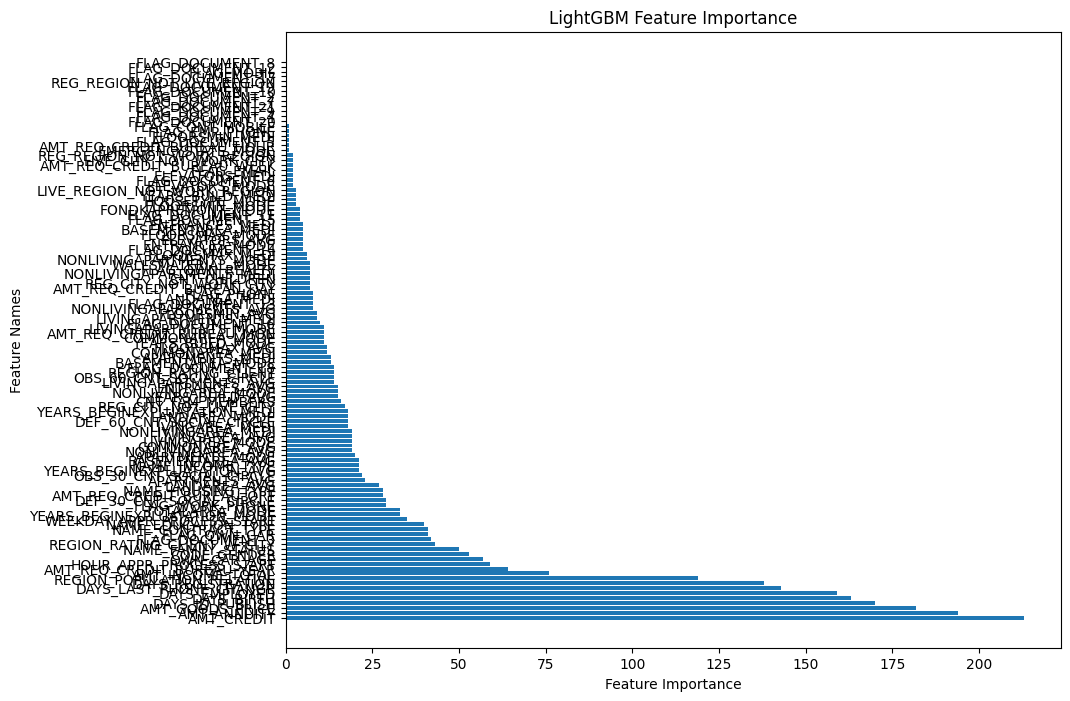

In [48]:
import matplotlib.pyplot as plt


lgb_feature_importance = lgb_model.feature_importances_
lgb_feature_names = X_train.columns

# Сортируем признаки по убыванию важности
sorted_idx = lgb_feature_importance.argsort()[::-1]
lgb_feature_names_sorted = [lgb_feature_names[i] for i in sorted_idx]
lgb_feature_importance_sorted = lgb_feature_importance[sorted_idx]

# Визуализация важности признаков с использованием горизонтального bar-plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), lgb_feature_importance_sorted, align='center')
plt.yticks(range(len(sorted_idx)), lgb_feature_names_sorted)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('LightGBM Feature Importance')
plt.show()


In [52]:

threshold = 100
lgb_selected_features = [feature for feature, importance in zip(lgb_feature_names_sorted, lgb_feature_importance_sorted) if importance >= threshold]

X_real_train_lgb_selected = X_train[lgb_selected_features]
X_real_test_lgb_selected = X_test[lgb_selected_features]

# Повторно обучили модель LightGBM на обновленных данных
lgb_model_selected = LGBMClassifier(random_state=42)
lgb_model_selected.fit(X_real_train_lgb_selected, Y_train)



[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2114
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771


LGBMClassifier(random_state=42)

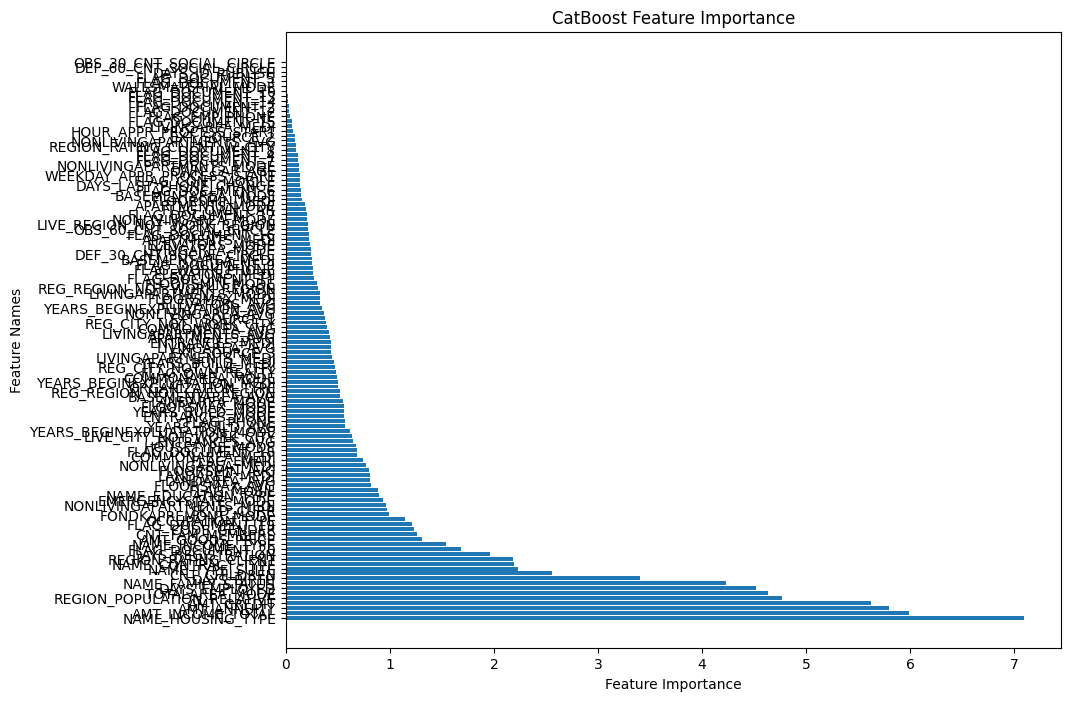

In [53]:
import matplotlib.pyplot as plt

# Заменили catboost_model на вашу обученную модель CatBoost
catboost_feature_importance = catboost_model.feature_importances_
catboost_feature_names = X_real_train.columns

# Сортируем признаки по убыванию важности
sorted_idx = catboost_feature_importance.argsort()[::-1]
catboost_feature_names_sorted = [catboost_feature_names[i] for i in sorted_idx]
catboost_feature_importance_sorted = catboost_feature_importance[sorted_idx]

# Визуализация важности признаков с использованием горизонтального bar-plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), catboost_feature_importance_sorted, align='center')
plt.yticks(range(len(sorted_idx)), catboost_feature_names_sorted)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('CatBoost Feature Importance')
plt.show()
